# Analyzing Moderation Behavior Similarity on Mastodon

Cosine Similarity and Louvain Community Detection were used to analyze how similar the behavior was used between different moderators flagging social-media posts on Mastodon. Cosine similarity was used to provide weights based on reasons for moderation and Louvain Community Decection was used to group moderators.

Note: code was formatted using [black](https://pypi.org/project/black/) to conform with PEP-8.

In [3]:
import pandas as pd  # This is used to load the df and convert matrix into df
import numpy as np  # This is used to create a unique color for each community by creating a list of evenly spaced numbers
import networkx as nx  # This is used for creating an undirected network and Louvain community detection
import matplotlib.pyplot as plt  # This is used for visualizing the plots
import scipy.sparse as sp #This is used to create a sparse matrix
from sklearn.metrics.pairwise import (
    cosine_similarity,
)  # This is used to compute the cosine similarity
from matplotlib.patches import (
    Patch,
)  # This is used to create a legend
from collections import (
    Counter,
)  # This is used to count the number of nodes in each community
import seaborn as sns  # This is used to plot the cosine similarity heatmap 

In [4]:
SIMILARITY_THRESHOLD = 0  # This sets the minimum cosine similarity value (0.2) required to consider two moderators similar enough to be connected in the graph


class ModerationData:
    """
    A class to hold Mastadon moderation data. Provides methods to filter, analyze, and visualize the data.
    """

    def __init__(self, file_path):  # This first method is used to initilize the object
        """
        Initializes the ModerationData class.

        Args:
            file_path (str): Path to the dataset file (CSV).
        """
        self.file_path = file_path  # This saves value of file_path into the object
        self.df = None  # This initializes the object ('None' because the data is loaded in the loading method)

    def load_data(self, datapath):
        """
        Loads the dataset into a pandas DataFrame and displays basic information.
        """
        self.df = pd.read_csv(
            datapath
        )  # This reads the df and assigns the df to the data attribute of the object
        self.df["blocking_reason"] = self.df[
            "blocking_reason"
        ].str.lower()  # This makes all strings in the 'blocking_reason' column lowercase, replacing the original df
        print("Dataset loaded successfully!")
        print()
        print("Data Frame Statistics:")
        print(self.df.info)  # This prints basic statistics
        print()
        print("First 5 rows of the dataset:")
        print(self.df.head())  # This prints first 5 rows of df

    def filter_blank(self):
        """
        Filter out data which doesn't having a moderation reason.
        """
        rows_before = len(
            self.df
        )  # This takes length of df (number of rows) before filtering
        self.df = self.df.dropna(
            subset=["blocking_reason"]
        )  # All the rows under the 'blocking_reason' column that are blank are dropped
        rows_after = len(
            self.df
        )  # This takes the length of df (number of rows) after filtering
        print(f"Missing values filtered out: {rows_before=} {rows_after=}")

    def filter_by_reasons(self, reasons_list):
        """
        Filters the dataset for specified moderation reasons and computes
        total weight for each source-target pair.

        Parameters:
        - reasons_list: list of 4 moderation reasons (e.g., ['Spam', 'Harassment', ...]).

        Returns:
        - A new DataFrame with columns: source, target, weight.
        """
        if not isinstance(reasons_list, list) or len(reasons_list) != 4:
            # This checks if it's not a list/not 4 items
            raise ValueError()  # The code is stopped and shows an error message
            print(
                f"Please provide a list of exactly four moderation reasons: {reasons_list=}"
            )
            return None

        filtered_df = self.df[
            self.df["blocking_reason"].isin(reasons_list)
        ]  # The data is filtered by whether or not the 'blocking_reason' column includes an item on 'reasons_list', creates a new df: 'filtered_data'

        grouped_df = (
            filtered_df.groupby(["source", "target"])["weight"].sum().reset_index()
        )  # The data is grouped by 'source'(moderator) and 'target'(who is moderated) columns and the sum of the weight of each of these pairs is taken, creating a new df: 'grouped_data'

        return grouped_df

    def construct_sparse_matrix(self, grouped_df):
        """
        Constructs a sparse matrix where rows represent target nodes and columns represent source nodes.
        """
        pivot_df = grouped_df.pivot_table(
            index="target", columns="source", values="weight", fill_value=0
        )  # This reshapes the data in matrix format where rows = target instances (who got moderated),
        # columns = source instances (who did the moderating), and values in the matrix = weight(how many times the source moderated the target)
        # All the values where moderation didn't happen are filled with a 0
        sparse_matrix = sp.csr_matrix(
            pivot_df.values
        )  # This converts the pivot table(regular 2D table of numbers) into a compressed format/sparse matrix, sparse matrix only stores non-zero values making it memory-efficient
        print(
            f"Sparse Matrix Created! Shape: {sparse_matrix.shape}"
        )  # The shape of the new sparse matrix is printed
        return sparse_matrix

    def calculate_cos_similarity(self, sparse_matrix):
        """
        Computes cosine similarity between source nodes (moderators).

        Args:
            sparse_matrix (csr_matrix): Sparse matrix representation of interactions.

        Returns:
            similarity_matrix (DataFrame): DataFrame containing cosine similarity values.
        """
        similarity_matrix = cosine_similarity(
            sparse_matrix.T
        )  # This calculates cosine similarity between all pairs of source instances (moderators) based on their moderation behavior (transposes matrix making rows = sources, columns = targets)
        moderators = self.df[
            "source"
        ].unique()  # This finds all unique moderators in df and stores them in variable 'moderators'
        similarity_df = pd.DataFrame(
            similarity_matrix, index=moderators, columns=moderators
        )  # This creates a new df from the similarity matrix where rows = moderators and columns = moderators

        print("Cosine Similarity Matrix:")
        print(
            similarity_df.head(10)
        )  # The first 10 values of similarity df are printed
        return similarity_df

    def create_graph(self, similarity_df):
        """
        Creates an undirected graph using the cosine similarity matrix and uses it to visualize the network.

        Args:
            similarity_df (DataFrame): Cosine similarity matrix.

        Returns:
            G(graph): Undirected graph between moderaters, with edge weights representing similarity values.
            There are only edges between moderators with similarity > 0.2.
        """
        # An undirected graph is created
        G = nx.Graph()

        for (
            moderator
        ) in (
            similarity_df.index
        ):  # This starts a loop going through each moderator in the rows of similarity_df
            G.add_node(moderator)  # This adds each moderator as a node to graph G

        for (
            mod1
        ) in (
            similarity_df.index
        ):  # This starts a loop going through each moderator (mod1) in rows of similarity_df
            for (
                mod2
            ) in (
                similarity_df.index
            ):  # This inner loop goes through every moderator (mod2), allowing comparison between mod1 and mod2 to check their similarity.
                if (
                    mod1 != mod2
                    and similarity_df.loc[mod1, mod2] > SIMILARITY_THRESHOLD
                ):
                    G.add_edge(mod1, mod2, weight=similarity_df.loc[mod1, mod2])
                    # If moderator 1 and moderator 2 aren't the same and their similarity score is higher than the threshold, an edge is added between them,
                    # the thickness of the edge is equal to their similarity score
        print(
            f"Graph Created Nodes: {G.number_of_nodes()}, Edges: {G.number_of_edges()}"
        )

        # The nodes are colored by the most common reason for blocking
        reason_counts = (
            self.df.groupby(["source", "blocking_reason"])
            .size()
            .reset_index(name="count")
            # This groups the df by each source(moderator) and their blocking reason,
            # counts how many times each combination appears, and creates a new df
        )
        most_common = reason_counts.loc[
            reason_counts.groupby("source")["count"].idxmax()
        ]  # This selects the most frequent blocking_reason for each source (moderator) by finding the row where each source has the highest count
        moderator_reasons = dict(
            zip(most_common["source"], most_common["blocking_reason"])
        )  # This creates a dictionary mapping each source (moderator) to their common blocking_reason
        for node in G.nodes():
            reason = moderator_reasons.get(node, "").lower()
            G.nodes[node]["reasons"] = reason
            # For each node (moderator) in the graph, this assigns their most common blocking_reason as a node attribute called 'reasons', in lowercase
        reason_color_map = (
            {  # This creates a color map, giving each reason a specific color
                "spam": "red",
                "harassment": "blue",
                "misinformation": "green",
                "hate-speech": "purple",
            }
        )
        node_colors = [
            reason_color_map[G.nodes[n]["reasons"]] for n in G.nodes()
        ]  # This creates a list of colors for each node based on their assigned
        # 'reasons' attribute using the reason_color_map

        # The network is visualized
        plt.figure(figsize=(8, 6))
        pos = nx.spring_layout(G)
        edges = G.edges(data=True)
        weights = [edge[2]["weight"] for edge in edges]
        nx.draw(
            G,
            pos,
            with_labels=False,
            node_color=node_colors,
            edge_color=weights,
            width=2,
        )  # This sets up the graph layout, extracts edge weights, and draws the graph with node colors based on reasons and edge colors/thickness based on
        # similarity weights using a blue colormap
        plt.title("Moderator Similarity Network")
        legend_elements = [
            Patch(facecolor=color, label=reason.capitalize())
            for reason, color in reason_color_map.items()
        ]
        plt.legend(handles=legend_elements, title="Moderation Reason", loc="best")
        # This creates colored legend boxes for each moderation reason using the reason_color_map and displays them in the graph legend titled 'Moderation Reason'
        return G

    def community_detection(self, G):
        """
        Detects communities in the moderator similarity network using the Louvain method, which groups nodes based on the shortest path between them.
        Provide a unique ID for each community for visualization.

        Args:
            G: Graph representing the moderator similarity network.

        Returns:
            node_community_map(dictionary): dictionary where each node is assigned to a community ID.
        """

        communities = nx.community.louvain_communities(
            G
        )  # This performs Louvain community detection

        # Each node is assigned to a community
        node_community_map = {}
        for i, comm in enumerate(communities):
            for node in comm:
                node_community_map[node] = (
                    i  # This creates a dictionary mapping each node to its community ID by assigning an index to each community and its nodes
                )

        print("Node Community Map (node: Community ID)")

        return node_community_map

    def summarise_community_info(self, node_community_map, min_community_size):
        """
        Visualize the distribution of communities and the number of nodes in each community (from greatest to least number of nodes).
        """
        
        community_sizes = Counter(
            node_community_map.values()
        )  # This counts the number of nodes in each community
        print("Number of instances in each community:")
        print(community_sizes)

        # Communities are filtered out that are too small to be relevant for visualization (if smaller than minimum community size)
        filtered_communities = {
            k: v for k, v in community_sizes.items() if v >= min_community_size
        }
        print("Filtered Communities:")
        print(filtered_communities)

        # The filtered_communities are sorted by size (largest to smallest) and reassigned IDs from 1 to n
        sorted_communities = sorted(
            filtered_communities.items(), key=lambda x: x[1], reverse=True
        )
        reassigned_community_map = {
            old_id: new_id
            for new_id, (old_id, _) in enumerate(sorted_communities, start=1)
        }  # This creates a dictionary that reassigns old community IDs to new sequential IDs (starting from 1) based on the sorted order of communities
        print("Sorted Communities")
        print(reassigned_community_map)

        # Node colors are updated for visualization
        num_filtered_comms = len(sorted_communities)
        community_colors = plt.cm.viridis(
            np.linspace(0, 1, num_filtered_comms)
        )  # This generates a list of distinct colors from the Viridis colormap,
        # evenly spaced for the number of filtered communities, to visually differentiate them

        plt.figure(figsize=(8, 5))
        plt.bar(
            [reassigned_community_map[old_id] for old_id, _ in sorted_communities],
            [size for _, size in sorted_communities],
            color=[community_colors[i - 1] for i in range(1, num_filtered_comms + 1)],
        )  # This creates a bar chart showing the sizes of filtered communities, with bars colored distinctly and labeled using renumbered community IDs

        plt.xlabel("Community ID (Renumbered)")
        plt.ylabel("Number of Nodes")
        plt.title(f"Community Distribution ({min_community_size=})")
        plt.xticks(
            range(1, num_filtered_comms + 1)
        )  # This creates x-axis ticks start from 1
        plt.show()

    def similarity_heat_map(self, similarity_df):
        """
        Generates and displays a heatmap showing cosine similarity between the top 20 most active or 
        connected moderators based on their total similarity scores. 
        """
        
        # This identifies the top 20 moderators based on total similarity scores (most connected/active)
        top_20 = similarity_df.sum(axis=1).sort_values(ascending=False).head(20).index

        # The top 20 moderators are extracted for the heatmap
        heatmap_data = similarity_df.loc[top_20, top_20]

        # The heatmap is plotted using Seaborn
        plt.figure(figsize=(12, 10))
        sns.heatmap(heatmap_data, cmap='Blues', square=True, linewidths=0.5)
        plt.title('Cosine Similarity Heatmap of Top 20 Moderators')
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()

    def centrality_analysis(self):
        """
        Constructs a moderation network graph and analyzes centrality metrics to identify key moderators.
        Two centrality measures are used:
        - Degree Centrality: Measures how many direct connections a node has (how active a moderator is).
        - Betweenness Centrality: Measures how often a node lies on the shortest path between other nodes (how much a moderator acts as a bridge or connector).
    
        The function visualizes the network, highlighting the most connected moderators with larger node sizes and labels.
        """

        G = nx.Graph() # This creates an empty undirected graph to hold all moderators and their connections.

        for _, row in self.df.iterrows(): # This adds edges between source (moderators) and targets (instance they moderated), each edge has a weight (how many times moderation happened)
            G.add_edge(row['source'], row['target'], weight=row['weight'])

        degree_centrality = nx.degree_centrality(G)  # This calculates the number of connections each node has, higher scores mean a more active/influential moderator

        betweenness_centrality = nx.betweenness_centrality(G, weight='weight')  # This calculates betweenness centrality, how important each node is as a "bridge", 
        # Higher scores mean it connects different groups and plays a key role in the information flow

        top_degree = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:5]  # This sorts all moderators by how many connections they have and prints out the top 5 most connected moderators
        print("Top Moderators by Degree Centrality:", top_degree)

        node_sizes = [8000 * degree_centrality[node] for node in G.nodes()]  # This makes more central nodes appear bigger in the graph

        plt.figure(figsize=(12, 10))  
        pos = nx.spring_layout(G, seed=42)  # This positions nodes so they're evenly spaced and visually appealing, uses spring layout: connected nodes are pulled together, unconnected ones push apart

        nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color='skyblue', alpha=0.7)  # This draws nodes (moderators + targets) with sizes based on centrality
        nx.draw_networkx_edges(G, pos, alpha=0.4)  # This draws edges (moderation actions) between them

        top_nodes = [node for node, _ in top_degree]  
        nx.draw_networkx_labels(G, pos, labels={node: node for node in top_nodes}, font_size=10) # This labels only the top 5 most central moderators so the graph doesn't get too cluttered

        #  The graph is shown
        plt.title("Moderation Network (Node Size = Degree Centrality)")
        plt.axis('off')
        plt.tight_layout()
        plt.show()

## Use ModerationData methods to analyze a given dataset.
## Task 1: Create similarity network

In [6]:
# Loading, cleaning, and filtering

mod_data = ModerationData("mastodon_edgelist_AE2.csv")
mod_data.load_data("mastodon_edgelist_AE2.csv")
print()
mod_data.filter_blank()
filtered_data = mod_data.filter_by_reasons(
    ["spam", "harassment", "misinformation", "hate-speech"]
)
filtered_data

Dataset loaded successfully!

Data Frame Statistics:
<bound method DataFrame.info of       source  target  weight blocking_reason
0      24331   26285      50      harassment
1      24331   48838      36            spam
2      24331   58140      34  misinformation
3      24331   25479      71      harassment
4      24331   41216      81  misinformation
...      ...     ...     ...             ...
2719   39320   59362      44  misinformation
2720   39320   20208      31     hate-speech
2721   39320    9959      32  misinformation
2722   39320   73232      59            spam
2723   39320   34774      35            spam

[2724 rows x 4 columns]>

First 5 rows of the dataset:
   source  target  weight blocking_reason
0   24331   26285      50      harassment
1   24331   48838      36            spam
2   24331   58140      34  misinformation
3   24331   25479      71      harassment
4   24331   41216      81  misinformation

Missing values filtered out: rows_before=2724 rows_after=2724


,source,target,weight
0,2448,519,32
1,2448,542,32
2,2448,9403,107
3,2448,11802,33
4,2448,12110,54
...,...,...,...
2719,68485,67189,69
2720,68485,69329,79
2721,68485,71826,38
2722,68485,73422,133


Sparse Matrix Created! Shape: (2276, 55)

Cosine Similarity Matrix:
          24331     11487     40846     3687      49537     64266  9613   \
24331  1.000000  0.000000  0.268156  0.000000  0.344327  0.000000    0.0   
11487  0.000000  1.000000  0.000000  0.072137  0.000000  0.000000    0.0   
40846  0.268156  0.000000  1.000000  0.000000  0.000000  0.000000    0.0   
3687   0.000000  0.072137  0.000000  1.000000  0.000000  0.000000    0.0   
49537  0.344327  0.000000  0.000000  0.000000  1.000000  0.000000    0.0   
64266  0.000000  0.000000  0.000000  0.000000  0.000000  1.000000    0.0   
9613   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000    1.0   
55898  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000    0.0   
68316  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000    0.0   
19420  0.000000  0.000000  0.000000  0.017687  0.000000  0.152408    0.0   

          55898  68316     19420  ...     44559  23977     68485     67191  \
24331  0.000000  

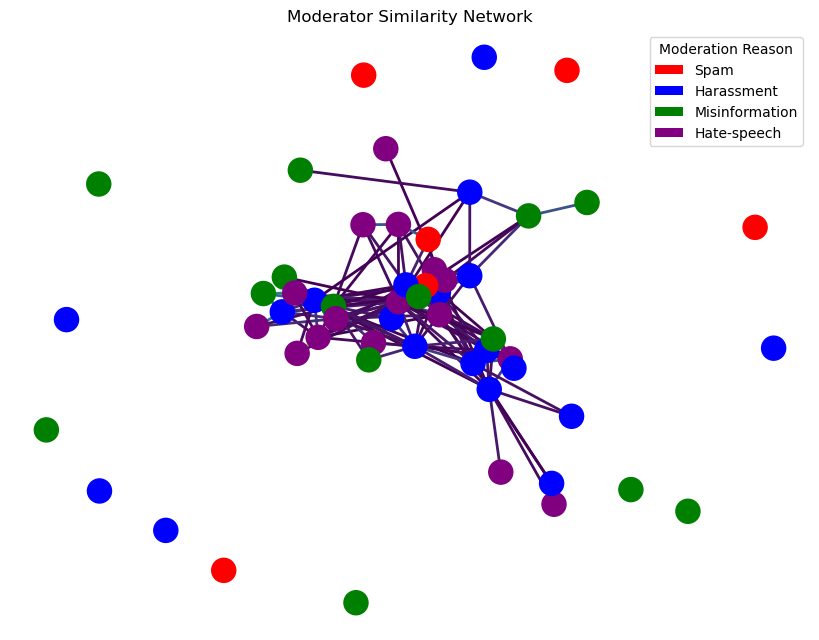

In [9]:
# Compute Cosine similarity and visualize the network

sparse_matrix = mod_data.construct_sparse_matrix(filtered_data)
print()
similarity_df = mod_data.calculate_cos_similarity(sparse_matrix)
G = mod_data.create_graph(similarity_df)

### Summary of Findings:

The analysis of moderation activities between Mastodon instances reveals a moderately connected network with both highly similar clusters of moderators and distinct outliers. The cosine similarity matrix shows that most instance pairs have low similarity scores, often close to 0.0, indicating that many moderators manage unique sets of targets or follow distinct moderation strategies. However, certain pairs exhibit high similarity scores (e.g., 0.365, 0.487), which suggests strong alignment in their moderation behavior, these pairs often appear as closely connected nodes in the network graph.

In the moderator similarity network, a central dense cluster of moderators is clearly visible. This cluster includes moderators handling harassment, hate-speech, and misinformation, represented by blue, purple, and green nodes respectively. These instances share multiple connections, revealing behavioral overlap and suggesting that they often moderate similar content types or common targets. In contrast, spam-focused moderators (red nodes) are often isolated, with few or no connections, highlighting the individualized nature of spam moderation and implying it is often addressed locally rather than collaboratively.

Among all moderation reasons, harassment and hate-speech were the most prevalent and most integrated into the network, while spam appeared less common and more fragmented. This suggests that shared challenges like harassment and hate-speech encourage more convergent behavior and potential collaboration between instances, while spam moderation is more case-specific.

Overall, the analysis reveals that Mastodon’s decentralized, federated structure allows for autonomy in moderation strategies, resulting in both independent actors and overlapping efforts among moderators. The key insight is that while most instances operate individually, clusters of behavioral similarity indicate opportunities for shared practices and collaborative moderation, especially around widespread issues like misinformation and harassment.

## Task 2: Identify and visualise the communities by performing community detection

Node Community Map (node: Community ID)
{59904: 0, 49537: 0, 68485: 0, 24331: 0, 40846: 0, 43633: 0, 26643: 0, 67191: 0, 22144: 1, 32421: 1, 3687: 1, 51240: 1, 35721: 1, 44559: 1, 21007: 1, 67859: 1, 63892: 1, 49630: 1, 68316: 2, 38172: 3, 23603: 4, 29825: 5, 60353: 6, 4872: 7, 58360: 8, 35130: 8, 18988: 8, 28680: 9, 38313: 9, 22540: 9, 11487: 9, 3813: 10, 64266: 10, 11376: 10, 15189: 10, 3765: 10, 55898: 10, 7003: 10, 19420: 10, 22219: 11, 60509: 12, 9613: 12, 35834: 13, 73392: 14, 68165: 15, 29595: 16, 2448: 17, 21089: 17, 52265: 17, 34039: 17, 23977: 18, 47320: 19, 59721: 20, 48127: 20, 39320: 21}
Number of instances in each community:
Counter({1: 10, 0: 8, 10: 8, 9: 4, 17: 4, 8: 3, 12: 2, 20: 2, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 11: 1, 13: 1, 14: 1, 15: 1, 16: 1, 18: 1, 19: 1, 21: 1})
Filtered Communities:
{0: 8, 1: 10, 8: 3, 9: 4, 10: 8, 12: 2, 17: 4, 20: 2}
Sorted Communities
{1: 1, 0: 2, 10: 3, 9: 4, 17: 5, 8: 6, 12: 7, 20: 8}


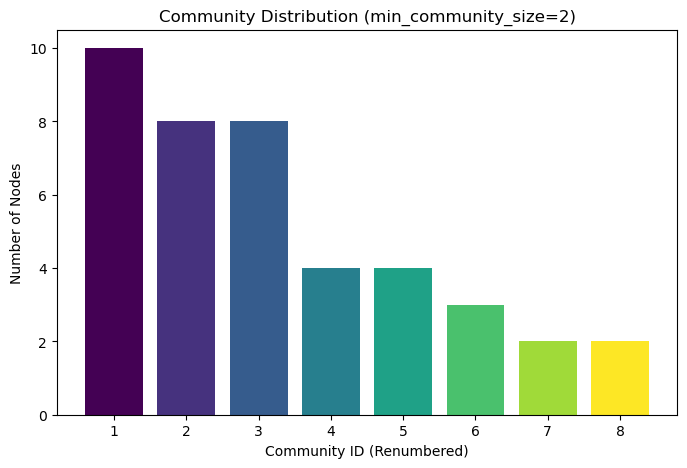

In [14]:
map = mod_data.community_detection(G)
print(map)
mod_data.summarise_community_info(map, 2)

### Summary of Findings:

The community detection analysis revealed that moderation behavior on Mastodon results in a highly fragmented network, where moderators cluster into small, distinct communities based on the similarity of their actions. From the community detection results, a total of 22 communities were initially identified, but only 8 communities met the minimum size threshold (≥2 instances) for meaningful analysis. These filtered communities vary in size, with the largest containing 10 instances and the smallest containing 2.

The distribution of instances across these communities, as shown in the bar chart, highlights a notable imbalance. Three communities dominate in size, containing 10, 8, and 8 instances respectively, while the remaining five have smaller memberships ranging from 2 to 4 instances. This suggests that while most moderators operate in small, behaviorally similar groups, there are a few larger clusters of moderators who exhibit strong alignment in moderation practices.

A key trend is that moderation behavior directly influences community structure. Instances that moderate similar targets or content types tend to group together, forming dense communities in the network graph. These larger communities likely reflect shared challenges or common content issues (e.g., harassment or misinformation), driving convergence in moderation actions. Conversely, smaller or more isolated communities may represent specialized moderation behaviors (e.g., spam-focused instances) or localized moderation needs.

The key takeaway is that Mastodon’s federated structure fosters both collaboration and independence in moderation. The formation of behaviorally similar communities indicates that some instances naturally align in how they handle content, while others remain distinct and individualized. This balance allows for both adaptability to local needs and opportunities for collaboration, particularly among instances facing similar moderation challenges. The data highlights how moderation strategies shape the social structure of the network, revealing shared priorities and potential for coordinated moderation efforts.










## Reflection

Working on this project was a significant learning experience that pushed me to explore many new areas of Python programming, data analysis, and network visualization. As someone relatively new to Python, I approached the task with a mix of excitement and uncertainty, especially given the complexity of some of the techniques involved. However, through consistent effort, problem-solving, and learning from my mistakes, I was able to complete the project and gain a much deeper understanding of data-driven analysis.

One of the first challenges I encountered came with creating the pivot table and converting it to a sparse matrix. Before this project (before lab 9), I had never worked with sparse matrices, so understanding why they were necessary (to save memory and improve efficiency) and how to create one using scipy.csr_matrix() required research and experimentation. Additionally, ensuring that the pivot table was correctly formatted with targets as rows, sources as columns, and weights as values, and filling in missing entries with zeros, required careful attention. Any errors in this step often led to incorrect matrix shapes or unexpected values, which in turn caused errors in later parts of the analysis. Debugging these issues taught me how to approach problems methodically, verifying each step before moving forward.

Calculating cosine similarity between moderators using the sparse matrix was another complex part of the project. I had to learn how to transpose the matrix to compare source instances accurately and understand how cosine similarity measures the angle between vectors to quantify behavioral similarity. Using the cosine_similarity() function and interpreting the resulting matrix was a breakthrough moment, especially when I realized that most similarity scores were low or zero. Understanding the implications of those low scores added valuable context to my network analysis.

Building the graph network from the similarity matrix was equally challenging. Writing a nested loop to compare every pair of moderators and determine whether to create an edge based on a similarity threshold required a solid understanding of logic and control flow. I had to ensure moderators weren’t compared to themselves and that only meaningful similarities resulted in graph connections. At first, visualizing the graph was overwhelming, but learning to assign colors to nodes based on their most common blocking reasons using dictionaries and Matplotlib’s Patch legend made the visualization far more insightful and intuitive.

Implementing Louvain community detection added another layer of complexity. Understanding how to use NetworkX’s community detection methods, mapping each node to a community ID, and filtering out smaller communities required a good grasp of enumeration, dictionary manipulation, and sorting. Generating distinct colors for each community using NumPy and Matplotlib’s colormaps was something I hadn’t done before, and it helped me appreciate the power of visual tools in conveying patterns in data.

Throughout this project, I learned to rely on incremental testing, using print statements and documentation to troubleshoot issues and understand how library functions worked. I also came to appreciate the value of clear code comments and modular design, both of which helped me manage and navigate the code as it became more complex. The techniques I used, including data filtering, sparse matrix construction, similarity calculation, and graph visualization, were all effective in uncovering meaningful patterns from the dataset.

Looking back, I learned several valuable lessons. Breaking down complex problems into smaller steps made them manageable. Debugging systematically and verifying outputs at each stage helped avoid bigger problems later. Visualizing data not only made it easier to interpret results but also revealed patterns that raw numbers couldn’t. Finally, I learned that reading documentation and understanding the tools at my disposal is crucial for effective problem-solving.

If I were to improve the project in future iterations, I would focus on enhancing interactivity in the visualizations, such as allowing users to explore the network graph dynamically. I would also improve error handling for user inputs and file loading, and perhaps add more statistical summaries of the graph’s properties to complement the visual analysis. Optimizing performance for larger datasets is another area I would explore, possibly by leveraging more efficient data structures or processing methods.

Overall, this project greatly expanded my confidence and ability in Python, especially in working with real-world datasets and applying analytical techniques to uncover insights. Completing it showed me that even as a beginner, with persistence and a willingness to learn, I could tackle advanced topics like network analysis and community detection. More importantly, I discovered that I enjoy the process of transforming complex data into meaningful insights through code and visualization.

## Task 4: Going Above and Beyond

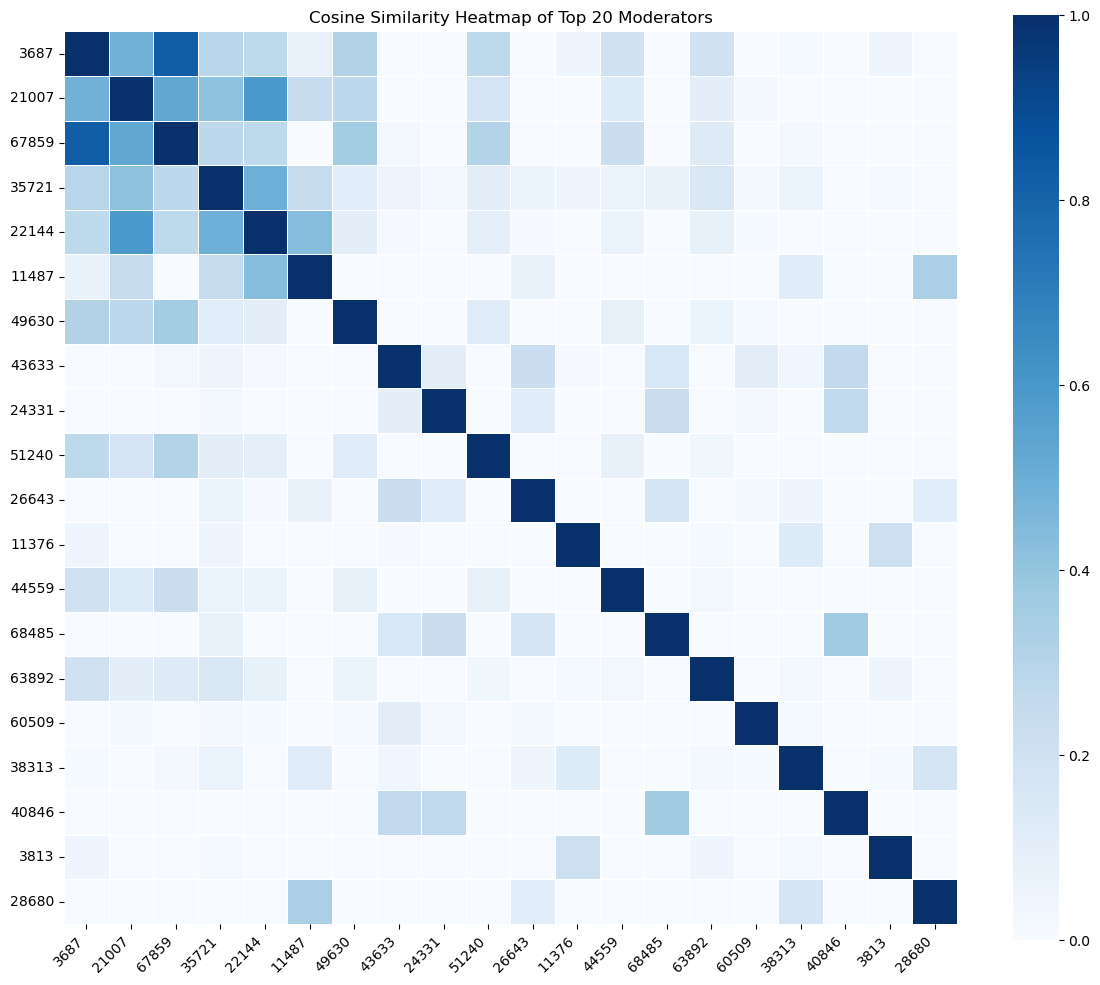

Top Moderators by Degree Centrality: [(15189, 0.3579399141630901), (32421, 0.2515021459227468), (24331, 0.09356223175965665), (40846, 0.08025751072961373), (35834, 0.061802575107296136)]


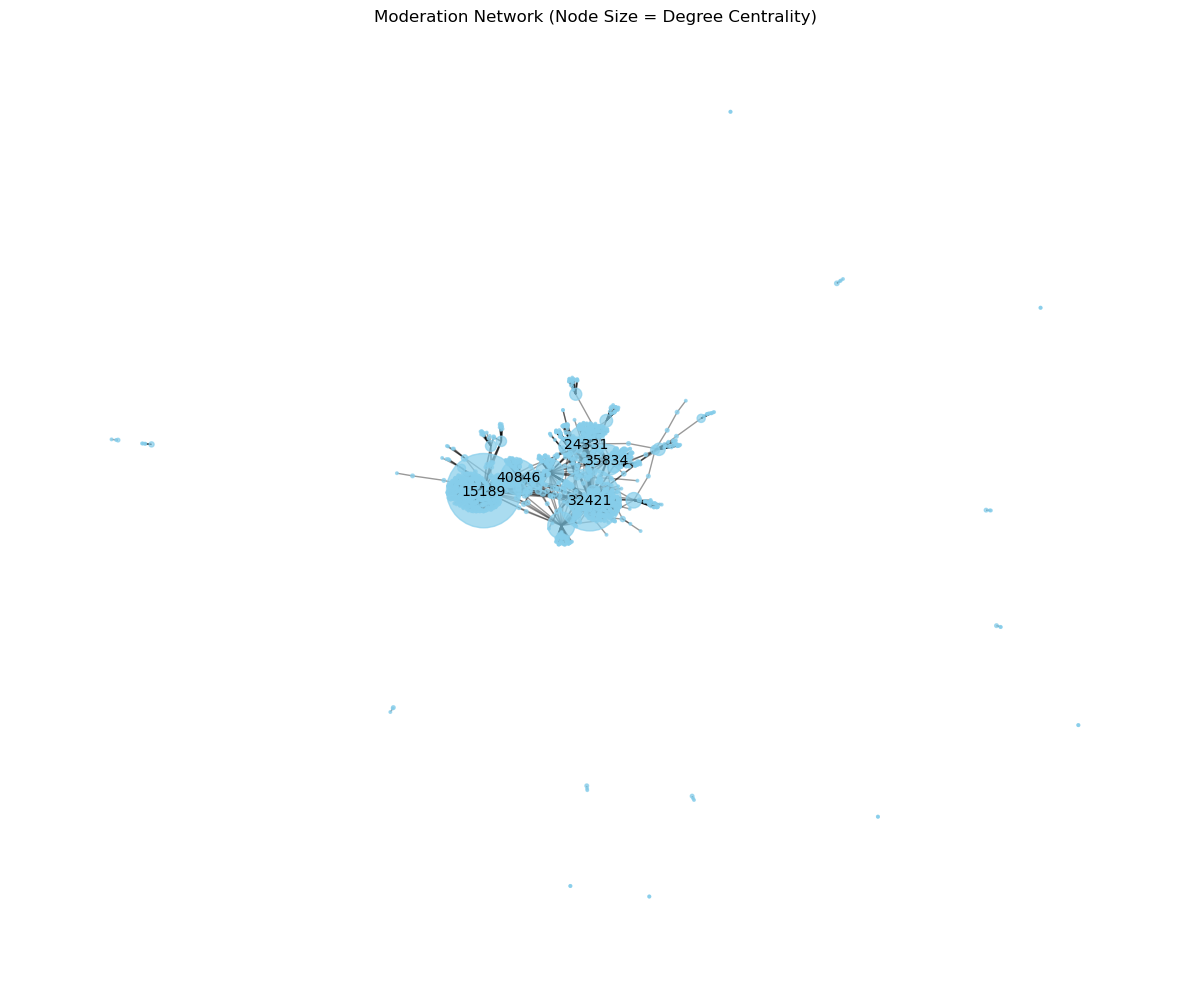

In [19]:
mod_data.similarity_heat_map(similarity_df)
mod_data.centrality_analysis()

## Summary of Findings:

To better understand the relationships between Mastodon moderator instances, two analyses were conducted: a cosine similarity heatmap and a moderation centrality network graph. These visualizations uncover patterns in moderation behavior and identify key instances within the network.

Cosine similarity measures how similarly moderators behave by comparing which instances they moderate and how often. If two moderators tend to moderate the same targets with similar frequency, they will have a high similarity score (closer to 1). A heatmap was created to visualize these similarity scores between the top 20 most active moderators.

The heatmap revealed that most moderators have very low similarity scores, meaning they tend to moderate different targets and follow unique moderation patterns. A few moderator pairs showed moderate similarity, suggesting some overlap in their moderation activity, possibly due to shared policies or common issues across instances. Overall, the lack of widespread similarity supports the idea that Mastodon’s moderation is highly decentralized, with each instance focusing on local or specific moderation needs.

A network graph was created where nodes represent moderator and target instances, and edges represent moderation actions between them. Using degree centrality (how many connections a node has), we identified which moderators are most active or influential. Node size was scaled based on centrality, making highly connected moderators appear larger.

The centrality network revealed a core group of highly connected moderators surrounded by many isolated or peripheral nodes. These central moderators play a major role in moderation activity, either by moderating many different targets or being central in shared moderation practices. In contrast, smaller or isolated nodes represent instances that moderate independently, further highlighting Mastodon’s federated and decentralized structure. The top moderators by degree of centrality serve as key influencers within the network, possibly handling larger or more active instances that require broader moderation efforts.

Together, these analyses show that while most moderators operate independently, a few play central roles and share behavioral similarities. The decentralized nature of Mastodon’s moderation system is evident, but these visualizations highlight opportunities for collaboration between similarly behaving instances, especially when addressing widespread issues like misinformation or harassment. These tools help identify not just how much moderation occurs, but how it’s structured across the network.